<a href="https://colab.research.google.com/github/Lailaehab/QRcode-preprocessing-decoding-project/blob/main/Preprocessing%2Bdecoding(Final_code).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

## Detect QR and Perspective function

In [ ]:
def get_corners(gray1):
  contours, hierarchy = cv2.findContours(gray1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  squares = []

  max_area = 0
  selected_contour = None
  for contour in contours:
      perimeter = cv2.arcLength(contour, True)
      approx = cv2.approxPolyDP(contour, 0.04 * perimeter, True)

      # Check if the polygon has at least 4 vertices
      if len(approx) >= 4:
          # Calculate the area of the contour
          area = cv2.contourArea(contour)
          if area > max_area:
              max_area = area
              selected_contour = approx

  # Convert the selected contour to a list of tuples for easier sorting
  contour_points = [tuple(point[0]) for point in selected_contour]

  # Find extreme points in each direction
  top_left = min(contour_points, key=lambda x: sum(x))
  top_right = max(contour_points, key=lambda x: (x[0], -x[1]))
  bottom_left = min(contour_points, key=lambda x: (x[0], -x[1]))
  bottom_right = max(contour_points, key=lambda x: sum(x))

  return top_left, top_right, bottom_left, bottom_right, selected_contour

## Detect QR


In [ ]:
def detect_qr(imageGray, imageBGR):
  img = imageGray
  original = imageBGR

  _, binary = cv2.threshold(img, 60, 255, cv2.THRESH_BINARY)

  # Apply edge detection method on the thresholded image
  edges = cv2.Canny(binary, 40, 150, apertureSize=3)

  # This returns an array of r and theta values
  lines = cv2. HoughLinesP(edges, 1,np. pi / 180, threshold=30, minLineLength=68, maxLineGap=220)
  img_with_lines = original.copy()
  if lines is not None:
      for line in lines:
          x1, y1, x2, y2 = line[0]
          cv2.line(img_with_lines, (x1, y1), (x2, y2), (0, 0, 255), 2)

  # Display the image with detected lines
  img_with_lines_only = np.zeros_like(original)
  if lines is not None:
      for line in lines:
          x1, y1, x2, y2 = line[0]
          cv2.line(img_with_lines_only, (x1, y1), (x2, y2), (0, 0, 255), 2)

  gray1 = cv2.cvtColor(img_with_lines_only, cv2.COLOR_BGR2GRAY)
  # Find contours on the edge-detected image

  top_left, top_right, bottom_left, bottom_right, selected_contour = get_corners(gray1)

  # Print or use the coordinates as needed
  print("Top Left:", top_left)
  print("Top Right:", top_right)
  print("Bottom Left:", bottom_left)
  print("Bottom Right:", bottom_right)


  rotated_corners = np.float32([bottom_left, bottom_right, top_left, top_right])


  # Draw contours on a new copy of the original image

  # Display the image with contours
  x, y, w, h = cv2.boundingRect(selected_contour)

  # Crop the detected object from the original image
  detected_object = original[y:y+h, x:x+w]
  # cv2_imshow(detected_object)
  # detected_object = cv2.resize(detected_object, (500, 500))
  # cv2_imshow(detected_object)
  return detected_object

## Rotate QR


In [ ]:
def rotate_qr_code(image, shift_x):
    """
    Rotate the QR code in the image based on the detected lines using Hough transform and move the frame to the right.
    """
    edges = cv2.Canny(image, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 100)
    if lines is None:
        print("None")
        return image  # Return the original image if no lines are detected
    # Compute the angle of tilt
    angles = []
    for line in lines:
        rho, theta = line[0]
        angles.append(theta)

    aligned = all(abs(np.degrees(theta) % 90) < 10 for theta in angles)  # 10 degrees tolerance

    if aligned:
        print("Rotation not done")
        return image  # Return the original image if QR code is aligned
    print("Rotation done")

    median_angle = np.median(angles)
    #angle_adjustment = np.degrees(median_angle) -180   # subtract 90 to make it clockwise rotation

    angle_deg = np.degrees(median_angle)
    nearest_90 = 90 * round(angle_deg / 90)
    #angle_adjustment = nearest_90 - angle_deg
    angle_adjustment = angle_deg - nearest_90

    # Rotate the QR code only
    height, width = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width / 2 + shift_x, height / 2), angle_adjustment, 1)

    # Apply translation to move the frame to the right
    rotation_matrix[0, 2] += shift_x

    # Apply replicate padding
    pad_size = shift_x
    padded_image = cv2.copyMakeBorder(image, 0, 0, pad_size, pad_size, cv2.BORDER_REPLICATE)

    # Create a white canvas of the same size as the input image
    white_canvas = np.ones_like(image) * 255

    # Rotate the image and blend it onto the white canvas with white border
    rotated_image = cv2.warpAffine(padded_image, rotation_matrix, (width + pad_size * 2, height), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
    rotated_on_white = cv2.warpAffine(white_canvas, rotation_matrix, (width + pad_size * 2, height), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

    # Mask out the rotated QR code from the white canvas
    result = cv2.bitwise_and(rotated_image, rotated_image)

    return result

## Locator box detection

In [ ]:
def detect_locator_boxes(image):
    # Convert the image to grayscale
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    # Use a Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Use Canny edge detection to find edges
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy of the input image to draw contours on
    image_with_contours = image.copy()

    # Filter contours based on area to find locator boxes
    locator_boxes = []
    for contour in contours:
        area = cv2.contourArea(contour)
        # print(area)
        if 50000 < area < 100000:  # Adjust this threshold based on your QR code size
            # Get the bounding box of the contour
            x, y, w, h = cv2.boundingRect(contour)
            locator_boxes.append((x, y, w, h))
            # Draw contours on the image copy
            # cv2.drawContours(image_with_contours, [contour], -1, (0, 255, 0), 2)

    return image_with_contours, locator_boxes

def is_qr_code_upside_down(locator_boxes):
    # Sort the locator boxes based on their x-coordinates
    sorted_boxes_y = sorted(locator_boxes, key=lambda box: box[1])
    # Check if the top-left locator box is above the top-right locator box
    # sort y
    if abs(sorted_boxes_y[0][1] - sorted_boxes_y[1][1]) < 8:
        # Good
        return False
    else:
        # Bad
        return True

def is_qr_code_flipped(locater_boxes):
  sorted_boxes_x = sorted(locater_boxes, key=lambda box: box[0])
  if abs(sorted_boxes_x[0][0] - sorted_boxes_x[1][0]) < 8:
      # Good
      return False
  else:
      # Bad
      return True

## rotate upside-down 180

In [ ]:
def rotate_upside_down(image):
# Check if QR code is upside down based on locator boxes
  image, locator_boxes = detect_locator_boxes(image)
  if locator_boxes:
      upside_down = is_qr_code_upside_down(locator_boxes)
      #flipped = is_qr_code_flipped(locator_boxes)
      if upside_down:
          print("Image is rotated upside down")
          rotated_image = cv2.rotate(image, cv2.ROTATE_180)
         # cv2_imshow(rotated_image)
          return rotated_image
      else:
          print("Image is not rotated upside down")
          return image

## Mirror

In [ ]:
def flip_image(image):
    image, locator_boxes = detect_locator_boxes(image)
    if locator_boxes:
          flipped = is_qr_code_flipped(locator_boxes)
          if flipped:
            print("QR code is flipped.")
            mirrored_image = cv2.flip(image, 1)
            return mirrored_image
          else:
            print("QR code is not flipped.")
            return image

## Invert colors

In [ ]:
def check_inversion_needed(image):
    """
    Detects if inversion of colors in a QR code might be needed based on mean intensity.

    Args:
    - image_path: Path to the QR code image file.

    Returns:
    - True if inversion might be needed, False otherwise.
    """
    # Load the image
    # img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate the mean pixel intensity of the QR code region
    mean_intensity = image.mean()

    # If mean intensity is greater than 127, no inversion is needed
    if mean_intensity > 127:
        print("Inversion not done")
        return image
    else:
      img = 255 - image
      print("Inversion done")
      return img

def invert_qr_if_needed_opencv(image):
    # Load the image in grayscale
   # img = cv2.imread(qr_image_path, cv2.IMREAD_GRAYSCALE)

    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Check the corners of the image to determine the predominant background color
    height, width = img.shape
    corner_pixels = [
        img[0, 0], img[width - 1, 0],
        img[0, height - 1], img[width - 1, height - 1]
    ]

    # Count how many corner pixels are dark
    dark_count = sum(1 for p in corner_pixels if p < 128)  # Threshold for dark pixels

    # Invert the image if most corner pixels are dark
    if dark_count > 2:
        img = 255 - img  # Invert the image

    return img

## preprocessing

In [ ]:
def preprocess_image(image):
    def brightness_adjustment(image):
        """
        Preprocess an input image by adjusting intensity, contrast, and brightness,
        and applying morphological operations if needed.

        Returns:
        - preprocessed_image (numpy.ndarray): Preprocessed image.
        """
        # Calculate mean intensity and standard deviation
        # image = cv2.equalizeHist(image)
        # cv2_imshow(image)
        mean_intensity = np.mean(image)
        std_dev_intensity = np.std(image)

        # Adjust contrast
        target_std_dev = 50  # Target standard deviation for contrast adjustment
        contrast_ratio = target_std_dev / std_dev_intensity
        adjusted_image = image * contrast_ratio

        # Adjust brightness
        target_mean_intensity = 127  # Target mean intensity for brightness adjustment
        brightness_offset = target_mean_intensity - mean_intensity
        adjusted_image += brightness_offset

        # Clip intensity values to [0, 255]
        adjusted_image = np.clip(adjusted_image, 0, 255)

        # Convert adjusted image back to uint8 datatype
        adjusted_image = adjusted_image.astype(np.uint8)

        return adjusted_image

    # Apply brightness adjustment
    # _, adjusted_image = cv2.threshold(adjusted_image, 50, 255, cv2.THRESH_BINARY)
    adjusted_image = brightness_adjustment(image)

    # Apply adaptive thresholding
    # adjusted_image= cv2.cvtColor(adjusted_image, cv2.COLOR_BGR2GRAY)
    adjusted_image = cv2.adaptiveThreshold(adjusted_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 199, 5)

    # Apply morphological closing
    kernel1 = np.ones((14, 14), np.uint8)
    adjusted_image = cv2.morphologyEx(adjusted_image, cv2.MORPH_CLOSE, kernel1)

    return adjusted_image

## Periodic Noise

In [ ]:
def periodic_noise(image):
  def find_peaks(magnitude_spectrum, threshold):
    # Threshold the magnitude spectrum
    thresholded_spectrum = magnitude_spectrum > threshold

    # Find peaks in the thresholded spectrum
    peaks = np.argwhere(thresholded_spectrum)

    return peaks

  def detect_periodic_noise(peaks):
    """
    Detect periodic noise based on peaks in the magnitude spectrum.

    Args:
    - peaks : Array of peak coordinates.

    Returns:
    - is_periodic (bool): True if periodic noise is detected, False otherwise.
    """
    if len(peaks) < 3:
        return False  # Need at least 3 peaks to form a pattern

    peak_distances = np.diff(peaks[:, 0])  # Differences between peak intensities along the vertical axis

    # Check if there is a repeating pattern in peak distances
    first_distance = peak_distances[0]
    is_periodic = True
    for distance in peak_distances[1:]:
        if distance != first_distance:
            is_periodic = False
            break

    return is_periodic

  def notch_reject_filter(image, peaks):
    # Calculate the Fourier transform of the image
    spec_orig = np.fft.fft2(image)
    spec_img = np.fft.fftshift(spec_orig)

    # Apply notch filter to remove specified frequencies
    for peak in peaks:
        n, j = peak
        spec_img[n, j] = 0

    # Reconstruct the image using inverse Fourier transform
    filtered_image = np.real(np.fft.ifft2(np.fft.ifftshift(spec_img)))
    return filtered_image

  spec_orig = np.fft.fft2(image)
  spec_img = np.fft.fftshift(spec_orig)
  magnitude_spectrum = np.log(np.abs(spec_img) + 1)

# Find peaks in the magnitude spectrum
  peaks = find_peaks(magnitude_spectrum, threshold=16)

# Detect periodic noise
  is_periodic_noise = detect_periodic_noise(peaks)
  print("Periodic noise", is_periodic_noise)

# Apply notch filter to remove periodic noise only if it exists
  if is_periodic_noise:
    filtered_image = notch_reject_filter(image, peaks)
  else:
    filtered_image = image  # If no periodic noise, retain original image


# Display the filtered image
  # plt.figure(figsize=(8, 6))
  # plt.imshow(filtered_image, cmap='gray')
  # plt.title('Filtered Image')
  # plt.axis('off')
  # plt.show()
  return filtered_image

## salt and noise

In [ ]:
def detect_salt_and_pepper_noise(image, threshold=0.02, kernel_size=3):
    # Convert image to grayscale
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply median filter to the image
    median_image = cv2.medianBlur(image, kernel_size)

    # Compute absolute difference between original and median filtered image
    diff_image = cv2.absdiff(image, median_image)

    # Compute threshold mask based on the threshold value
    _, mask = cv2.threshold(diff_image, 255 * threshold, 255, cv2.THRESH_BINARY)

    # Count the number of white pixels in the mask
    num_white_pixels = np.sum(mask == 255)

    # Calculate the percentage of white pixels in the mask
    height, width = mask.shape
    percentage_white_pixels = (num_white_pixels / (height * width)) * 100

    # Determine if salt and pepper noise is present based on the percentage of white pixels
    if percentage_white_pixels > threshold * 100:
        print("Salt pepper", "True")
        return True
    else:
        print("Salt pepper", "False")
        return False

## Shift Pixel

In [ ]:
def shifting_pixel(binary_qr_code):
  # Read the image in grayscale
  # qr_code = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

  # # Convert image to binary (black and white)
  # _, binary_qr_code = cv2.threshold(qr_code, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  # Initialize the aligned QR code array
  aligned_qr_code_full = np.ones_like(binary_qr_code) * 255

  # Determine the expected x-coordinate of the alignment pattern from the left
  expected_positions = []
  for y in range(binary_qr_code.shape[0] // 2):  # only take the top half
    row = binary_qr_code[y, :]
    first_black_pixel_index = np.where(row == 0)[0]
    if first_black_pixel_index.size > 0:
        expected_positions.append(first_black_pixel_index[0])
  expected_x = int(np.median(expected_positions))

  print("expected_x", expected_x)
  if expected_x != 19:
    return binary_qr_code
  #expected_x = int(np.median(expected_positions))

  # Determine the expected x-coordinate of the alignment pattern from the right
  expected_positions1 = []
  for y in range(binary_qr_code.shape[0] // 2):  # only take the top half
    row = binary_qr_code[y, ::-1]  # flip the row to process from right to left
    first_black_pixel_index = np.where(row == 0)[0]
    if first_black_pixel_index.size > 0:
        expected_positions1.append(first_black_pixel_index[0])
  expected_x_from_right = int(np.median(expected_positions1))

  # Align each row based on the expected x-coordinate
  for y, row in enumerate(binary_qr_code):
      first_black_pixel_index = np.where(row == 0)[0]
      if first_black_pixel_index.size > 0:
          shift_amount = expected_x - first_black_pixel_index[0]
          if abs(shift_amount) > 100:
              row_reversed = row[::-1]  # process from right to left
              first_black_pixel_index_reversed = np.where(row_reversed == 0)[0]
              if first_black_pixel_index_reversed.size > 0:
                  shift_amount = expected_x_from_right - first_black_pixel_index_reversed[0]
                  if abs(shift_amount) > 20:
                      shift_amount = 0
                  aligned_qr_code_full[y] = np.roll(row, -shift_amount)
          else:
              aligned_qr_code_full[y] = np.roll(row, shift_amount)

  return aligned_qr_code_full



## perspective

In [ ]:
def perspective(imageGray, imageBGR):
  img = imageGray
  original = imageBGR

  _, binary = cv2.threshold(img, 60, 255, cv2.THRESH_BINARY)

  # Apply edge detection method on the thresholded image
  edges = cv2.Canny(binary, 40, 150, apertureSize=3)

  # This returns an array of r and theta values
  lines = cv2. HoughLinesP(edges, 1,np. pi / 180, threshold=30, minLineLength=68, maxLineGap=220)
  img_with_lines = original.copy()
  if lines is not None:
      for line in lines:
          x1, y1, x2, y2 = line[0]
          cv2.line(img_with_lines, (x1, y1), (x2, y2), (0, 0, 255), 2)

  # Display the image with detected lines
  img_with_lines_only = np.zeros_like(original)
  if lines is not None:
      for line in lines:
          x1, y1, x2, y2 = line[0]
          cv2.line(img_with_lines_only, (x1, y1), (x2, y2), (0, 0, 255), 2)

  gray1 = cv2.cvtColor(img_with_lines_only, cv2.COLOR_BGR2GRAY)
  # Find contours on the edge-detected image

  top_left, top_right, bottom_left, bottom_right, selected_contour = get_corners(gray1)

  # print("PERSPECTIVE")
  # print("Top Left:", top_left)
  # print("Top Right:", top_right)
  # print("Bottom Left:", bottom_left)
  # print("Bottom Right:", bottom_right)

  a = abs((float(top_left[0]) - float(top_left[1])))
  b = abs(float(bottom_right[0]) - float(bottom_right[1]))
  if abs(a < 20) or abs(b < 20):
    print("Perspective not done")
    return imageGray, False
  print("Perspective done")

  selected_contour_sorted = selected_contour.reshape(-1, 2)
  selected_contour_sorted = selected_contour_sorted[np.argsort(selected_contour_sorted[:, 0])]

  # Determine top-left and bottom-left vertices
  if selected_contour_sorted[0][1] < selected_contour_sorted[1][1]:
      top_left = selected_contour_sorted[0]
      bottom_left = selected_contour_sorted[1]
  else:
      top_left = selected_contour_sorted[1]
      bottom_left = selected_contour_sorted[0]

  # Determine top-right and bottom-right vertices
  if selected_contour_sorted[2][1] < selected_contour_sorted[3][1]:
      top_right = selected_contour_sorted[2]
      bottom_right = selected_contour_sorted[3]
  else:
      top_right = selected_contour_sorted[3]
      bottom_right = selected_contour_sorted[2]

  if abs(bottom_right[0] - bottom_right[1]) < 60:
    bottom_right = (max(bottom_right), max(bottom_right))

  if abs(top_left[0] - top_left[1]) < 60:
    top_left = (min(top_left), min(top_left))


  rotated_corners = np.float32([bottom_left, bottom_right, top_left, top_right])

  # Define the corrected region (adjust dimensions as needed)
  new_corners = np.float32([bottom_left, [top_right[0], bottom_left[1]], [bottom_left[0], top_right[1]], top_right])


  # Compute the perspective transformation matrix
  perspective_matrix = cv2.getPerspectiveTransform(rotated_corners, new_corners)

  # Apply the perspective transformation to the image
  corrected_image = cv2.warpPerspective(original, perspective_matrix, (1011, 1011))
  return corrected_image, True

## Remove Salt and Pepper

In [ ]:
def remove_salt_and_pepper_noise(image_salt, kernel_size=21):


    kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21))
    kernel4 = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))

    denoised_image = cv2.blur(image_salt, (11, 11))

    _, denoised_image = cv2.threshold(denoised_image, 125, 255, cv2.THRESH_BINARY)


    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

    denoised_image = cv2.medianBlur(denoised_image, kernel_size)

    denoised_image = cv2.morphologyEx(denoised_image, cv2.MORPH_CLOSE, kernel4, iterations=2)

    # Apply closing to enhance the remaining features of the QR code

    kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21))
    kernel4 = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))


    denoised_image = cv2.morphologyEx(denoised_image, cv2.MORPH_OPEN, kernel2, iterations=4)

    # img = cv2.resize(denoised_image, (100,100))

    return denoised_image

## Blur

In [ ]:
def is_blurred(image, threshold=5):
    # Compute the Laplacian of the image
    laplacian = cv2.Laplacian(image, cv2.CV_64F).var()
    # print("Laplacian", laplacian)

    # Check if the variance is below the threshold
    if 1.5 < laplacian < 3:
        print('Blurred True')
        return True
    else:
        print('Blurred False')
        return False

In [ ]:
def remove_blur(image):

  # Apply a sharpening filter
  sharpening_kernel = np.array([[-3, -3, -3],
                                [-3, 32, -3],
                                [-3, -3, -3]])
  sharpened = cv2.filter2D(image, -1, sharpening_kernel)


  # Apply adaptive thresholding to create a binary image
  _, binary = cv2.threshold(sharpened, 170, 255, cv2.THRESH_BINARY)

  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 8))

  dilated = cv2.erode(binary, kernel, iterations=1)

  kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))

  kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))



  dilated = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel3, iterations=1)

  dilated = cv2.erode(dilated, kernel, iterations=2)

  return dilated

## Histrogram Equilization

In [ ]:
def check_and_equalize(image):
    gray = image
    # Compute histogram
    hist, bins = np.histogram(gray.flatten(), 256, [0,256])

    # Calculate cumulative distribution function (CDF)
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()

    # Check if histogram is skewed
    spread = np.diff(cdf_normalized)
    spread_mean = np.mean(spread)
    print(spread_mean)
    if  1300 < spread_mean < 2200:
        print("Image may benefit from histogram equalization")

        # Apply histogram equalization
        equalized = cv2.equalizeHist(gray)

        # If image was color, convert back to color
        if len(image.shape) == 3:
            equalized = cv2.cvtColor(equalized, cv2.COLOR_GRAY2BGR)

        return equalized
    else:
        print("Histogram is already well spread")
        return image

## Opening and Closing

In [ ]:
def openClose(image):
  final= cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                            cv2.THRESH_BINARY, 199, 5)
  kernel1 = np.ones((30, 20), np.uint8)
  denoised_image = cv2.morphologyEx(final, cv2.MORPH_OPEN, kernel1)
  kernel = np.ones((6, 6), np.uint8)
  denoised_image = cv2.morphologyEx(denoised_image, cv2.MORPH_CLOSE, kernel)
  kernel2 = np.ones((44, 44), np.uint8)
  denoised_image = cv2.morphologyEx(denoised_image, cv2.MORPH_OPEN, kernel2)

  return denoised_image

## Alphanumeric Decoding

In [ ]:
def alphanumeric_decoding(img):
    # Apply thresholding to preprocess the img
    _, thresh_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours in the thresholded img
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Iterate through the contours and filter alphanumeric characters based on aspect ratio and area
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h
        area = cv2.contourArea(contour)
        if aspect_ratio > 0.2 and aspect_ratio < 5 and area > 100:
            # Draw bounding boxes around the alphanumeric characters
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return img

## After preprocessing

In [ ]:
def after_preprocessing(image):
  blurred = cv2.GaussianBlur(image, (7, 7), 0)

  # Applying threshold
  threshold = cv2.threshold(blurred, 0, 255,
      cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

  # Apply the Component analysis function
  analysis = cv2.connectedComponentsWithStats(threshold,
                                              4,
                                              cv2.CV_32S)
  (totalLabels, label_ids, values, centroid) = analysis

  # Initialize a new image to store
  # all the output components
  output = np.zeros(image.shape, dtype="uint8")

  # Loop through each component
  for i in range(1, totalLabels):

        # Area of the component
      area = values[i, cv2.CC_STAT_AREA]

      if (area > 0) and (area < 300):
          componentMask = (label_ids == i).astype("uint8") * 255
          output = cv2.bitwise_or(output, componentMask)

  # output =255-output
  final=255 -image
  final2=final-output
  final2=255 -final2
  kernel = np.ones((5,  1), np.uint8)
  final2 = cv2.dilate(final2, kernel, iterations=1)
  final2 = cv2.erode(final2, kernel, iterations=1)

  return final2

## All Images

In [ ]:
all_images = [
    '/content/01-Getting-started.png',
    '/content/02-Matsawar-3edel-ya3am.png',
    '/content/03-Leffy-bina-ya-donya.png',
    '/content/04-Black-mirror.png',
    '/content/05-Caesar-cipher.png',
    '/content/06-Railfence-cipher.png',
    # '/content/07-THE-MIGHTY-FINGER.png',
    '/content/08-Compresso-Espresso.png',
    '/content/09-My-phone-fell-while-taking-this-one-...-or-did-it.png',
    '/content/10-Gone-With-The-Wind.png',
    '/content/11-weewooweewooweewoo.png',
    '/content/12-mal7-w-felfel.png',
    '/content/13-2el-noor-2ata3.png',
]

## Run Preprocessing

Salt pepper False
Periodic noise False
Blurred False
997.1555103004816
Histogram is already well spread
Inversion done
Perspective not done
False
Image is not rotated upside down
QR code is flipped.
Top Left: (42, 43)
Top Right: (968, 44)
Bottom Left: (41, 969)
Bottom Right: (966, 970)
expected_x 2


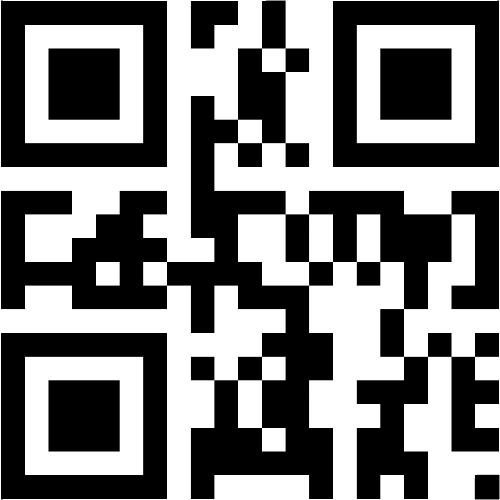

In [ ]:
def Preprocessing(imageGray, perspectiveDone):


  imageGray = cv2.cvtColor(imageGray, cv2.COLOR_BGR2GRAY)

  saltpepper=detect_salt_and_pepper_noise(imageGray)
  if saltpepper:
    imageGray=remove_salt_and_pepper_noise(imageGray)

  imageGray=periodic_noise(imageGray)

  blurred=is_blurred(imageGray)
  if blurred:
    imageGray=remove_blur(imageGray)

  try:
    imageGray=check_and_equalize(imageGray)
  except:
    print("HISTOGRAM EQUILIZATION EXCEPTION PASSED")

  imageGray=preprocess_image(imageGray)
  imageGray=check_inversion_needed(imageGray)

  _, locator_boxes = detect_locator_boxes(imageGray)

  oldImg = imageGray
  try:
    if len(locator_boxes) == 3:
      imageBGR = cv2.cvtColor(imageGray, cv2.COLOR_GRAY2BGR)
      imageGray, perspectiveDone=perspective(imageGray, imageBGR)
      print(perspectiveDone)

      imageGray=rotate_upside_down(imageGray)
      imageGray=flip_image(imageGray)

      imageRGB = cv2.cvtColor(imageGray, cv2.COLOR_BGR2RGB)
      image=detect_qr(imageGray, imageRGB)
      imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      # imageGray=rotate_qr_code(imageGray, 0)
  except:
    print("EXCEPTION")
    return oldImg, perspectiveDone

  return imageGray, perspectiveDone

perspectiveDone = False
image=cv2.imread("/content/04-Black-mirror.png")

image, perspectiveDone=Preprocessing(image, perspectiveDone)
image=shifting_pixel(image)
image = cv2.resize(image, (500, 500))

if not perspectiveDone:
  # print("ENTERED")
  image = after_preprocessing(image)

cv2_imshow(image)

Salt pepper False
Periodic noise False
Blurred False
1317.5979486800109
Image may benefit from histogram equalization
Inversion not done
Perspective not done
False
Image is not rotated upside down
QR code is not flipped.
Top Left: (46, 43)
Top Right: (969, 45)
Bottom Left: (43, 967)
Bottom Right: (924, 969)
expected_x 2
Test case 1


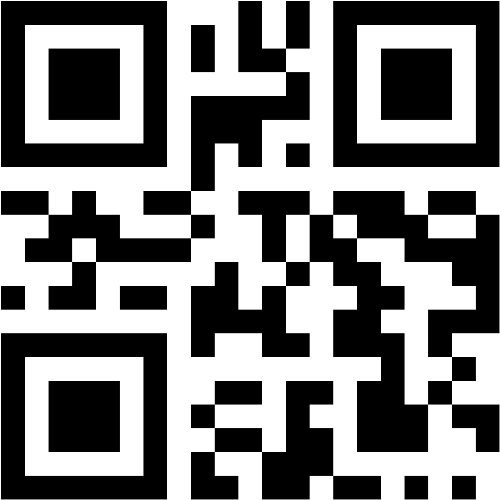

Salt pepper False
Periodic noise False
Blurred False
1462.6042872188011
Image may benefit from histogram equalization
Inversion not done
expected_x 22
Test case 2


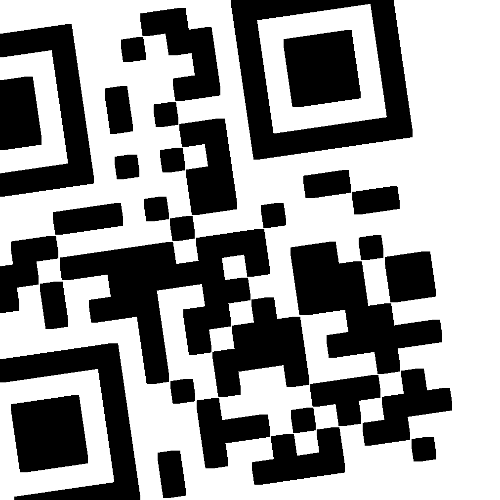

Salt pepper False
Periodic noise False
Blurred False
1335.0496250029485
Image may benefit from histogram equalization
Inversion not done
Perspective not done
False
Image is rotated upside down
QR code is not flipped.
Top Left: (44, 41)
Top Right: (967, 43)
Bottom Left: (41, 965)
Bottom Right: (922, 967)
expected_x 2
Test case 3


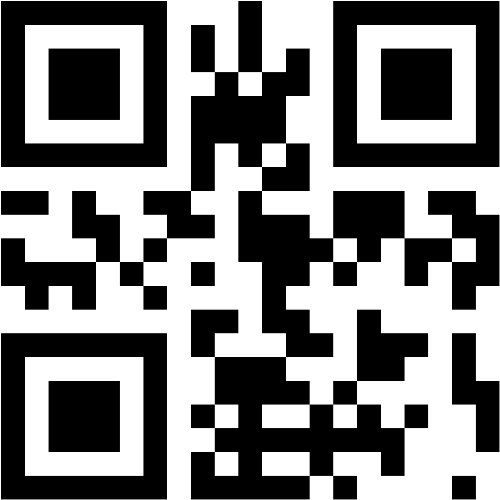

Salt pepper False
Periodic noise False
Blurred False
997.1555103004816
Histogram is already well spread
Inversion done
Perspective not done
False
Image is not rotated upside down
QR code is flipped.
Top Left: (42, 43)
Top Right: (968, 44)
Bottom Left: (41, 969)
Bottom Right: (966, 970)
expected_x 2
Test case 4


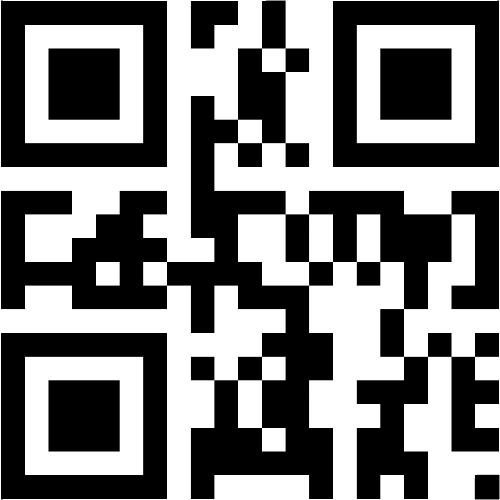

Salt pepper False
Periodic noise False
Blurred False
1100.5958831961134
Histogram is already well spread
Inversion not done
expected_x 19
Test case 5


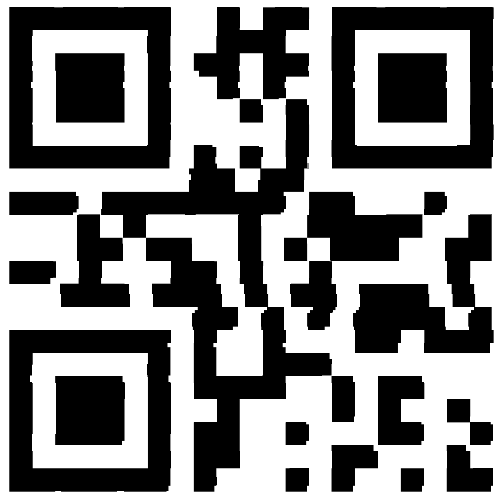

Salt pepper False
Periodic noise False
Blurred False
2219.002506709381
Histogram is already well spread
Inversion not done
Perspective done
True
Image is not rotated upside down
QR code is not flipped.
Top Left: (71, 95)
Top Right: (979, 112)
Bottom Left: (64, 951)
Bottom Right: (967, 950)
expected_x 4
Test case 6


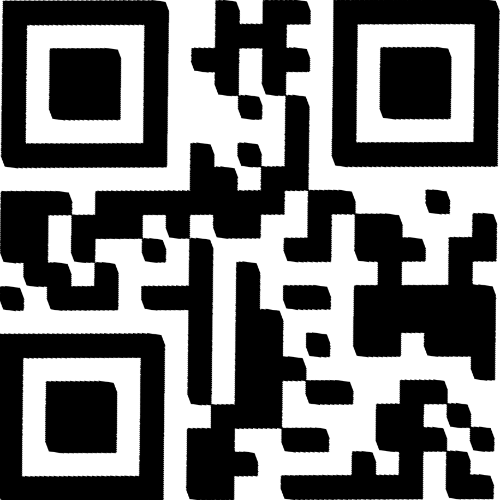

Salt pepper False
Periodic noise False
Blurred False
2465.2627450980394
Histogram is already well spread
Inversion not done
expected_x 45
Test case 7


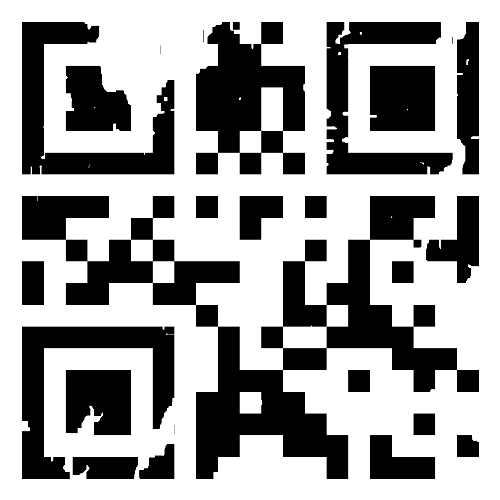

Salt pepper False
Periodic noise False
Blurred True
1405.3270488157457
Image may benefit from histogram equalization
Inversion not done
Perspective not done
False
Image is not rotated upside down
QR code is not flipped.
Top Left: (36, 51)
Top Right: (953, 47)
Bottom Left: (36, 51)
Bottom Right: (952, 906)
expected_x 1
Test case 8


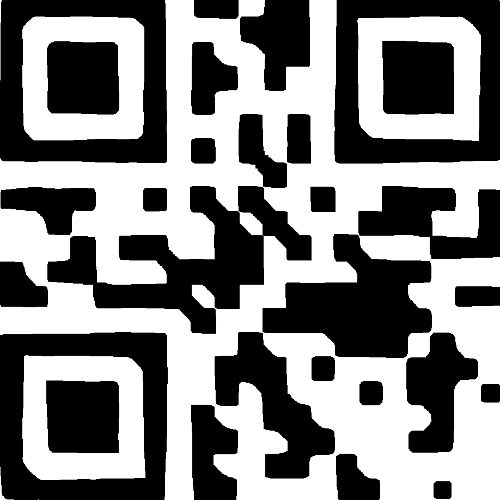

Salt pepper False
Periodic noise False
Blurred False
2199.6392156862744
Image may benefit from histogram equalization
Inversion not done
expected_x 241
Test case 9


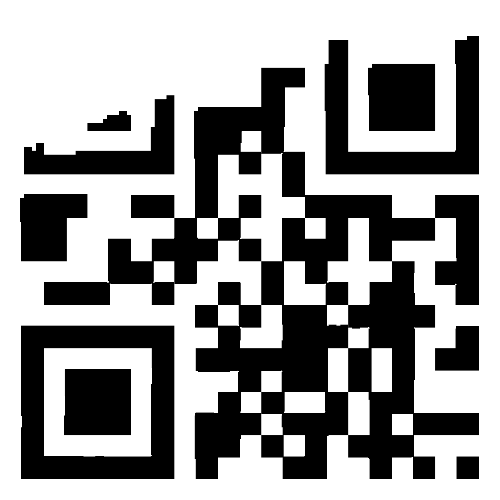

Salt pepper False
Periodic noise True
Blurred False
131.72668667307084
Histogram is already well spread
Inversion not done
expected_x 41
Test case 10


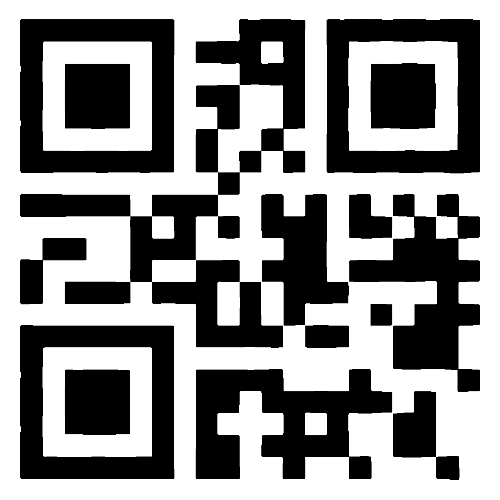

Salt pepper True
Periodic noise False
Blurred False
1281.0671114302556
Histogram is already well spread
Inversion not done
Perspective not done
False
Image is not rotated upside down
QR code is not flipped.
Top Left: (52, 44)
Top Right: (966, 86)
Bottom Left: (39, 95)
Bottom Right: (921, 968)
expected_x 6
Test case 11


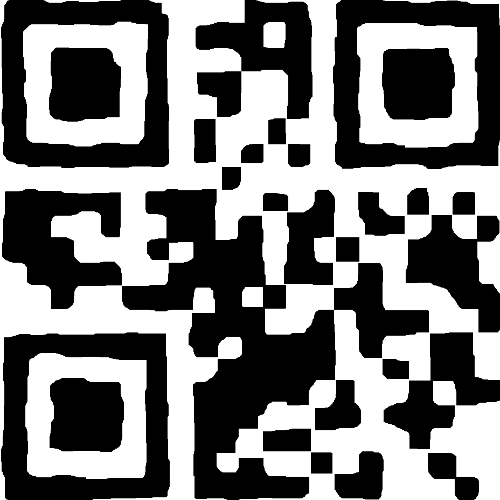

Salt pepper False
Periodic noise False
Blurred False
1368.922179835158
Image may benefit from histogram equalization
Inversion not done
expected_x 45
Test case 12


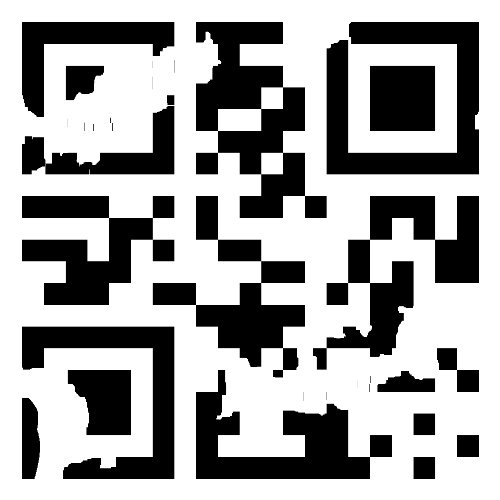

In [ ]:
for index, img in enumerate(all_images):
  perspectiveDone = False
  image=cv2.imread(img)

  image, perspectiveDone=Preprocessing(image, perspectiveDone)
  image=shifting_pixel(image)
  image = cv2.resize(image, (500, 500))
  if not perspectiveDone:
    # print("ENTERED")
    image = after_preprocessing(image)

  print(f"Test case {index+1}")
  cv2_imshow(image)

# Decoder

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
!pip install --upgrade reedsolo
import reedsolo as rs

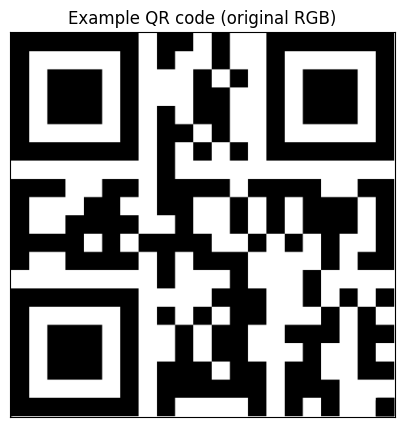

In [ ]:
img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
fig = plt.figure(figsize=(5, 5));
plt.xticks([], []);
plt.yticks([], []);
plt.title('Example QR code (original RGB)')
plt.imshow(img, cmap='gray');

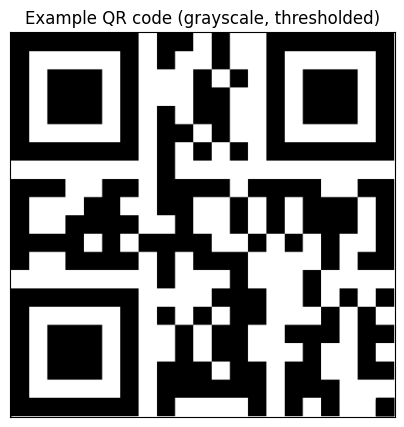

In [ ]:
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
_, img3 = cv2.threshold(img, 142, 255, cv2.THRESH_BINARY)
fig = plt.figure(figsize=(5, 5));
plt.xticks([], []);
plt.yticks([], []);
plt.title('Example QR code (grayscale, thresholded)')
# resized_image = cv2.resize(img, (21, 21))
plt.imshow(img, cmap='gray');

1 499 1 499
Width: 498
Height: 498
difference between height and width 0
min side 498
Size of QR code: 498
grid_cell_size :  24
(504, 504)
Width: 498
Height: 498


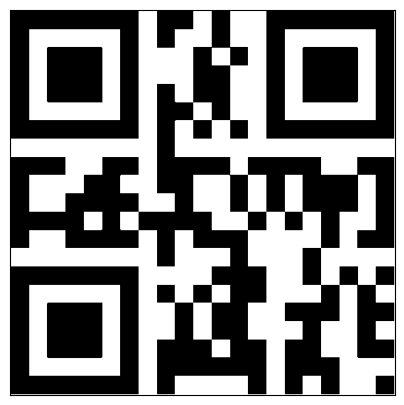

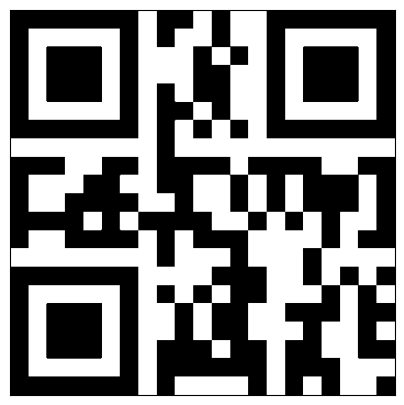

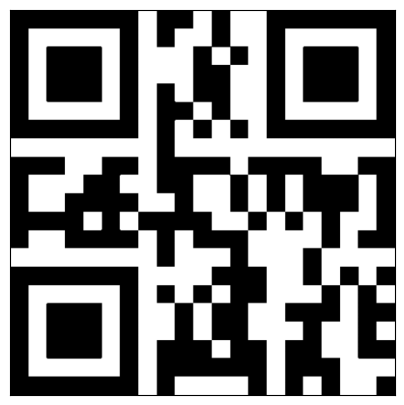

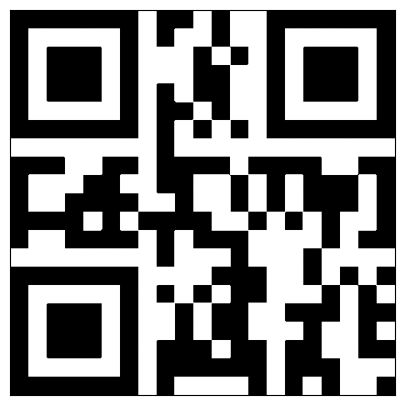

In [ ]:
start_row = -1
start_col = -1
end_row = -1
end_col = -1

fig = plt.figure(figsize=(5, 5));
plt.xticks([], []);
plt.yticks([], []);
plt.imshow(img3, cmap='gray');
for row_index, row in enumerate(img3):
    for pixel in row:
        if pixel != 255:
            start_row = row_index
            break
    if start_row != -1:
        break

for row_index, row in enumerate(img3[::-1]):
    for pixel in row:
        if pixel != 255:
            end_row = img3.shape[0] - row_index
            break
    if end_row != -1:
        break

for col_index, col in enumerate(cv2.transpose(img3)):
    for pixel in col:
        if pixel != 255:
            start_col = col_index
            break
    if start_col != -1:
        break

for col_index, col in enumerate(cv2.transpose(img3)[::-1]):
    for pixel in col:
        if pixel != 255:
            end_col = img3.shape[1] - col_index
            break
    if end_col != -1:
        break

img3_no_quiet_zone = img3[start_row:end_row, start_col:end_col]

print(start_row, end_row, start_col, end_col)

# while(((end_col - start_col) % 21) !=0):
#   end_col =end_col -1


# while(((end_row - start_row) % 21) !=0):
#   start_row =start_row -1

# print(end_col)


width = end_col - start_col
height = end_row - start_row

# Print the size of each side
print("Width:", width)
print("Height:", height)
diff= abs(width - height)
print("difference between height and width",diff)
row=min(width , height)
print('min side' , row)

if(diff<20):

    if (width < height):
      start_col=start_col - diff
    else:
      start_row=start_row - diff



fig = plt.figure(figsize=(5, 5));
plt.xticks([], []);
plt.yticks([], []);
img3=img3[start_col:end_col, start_row:end_row]
plt.imshow(img3, cmap= 'gray');


width = end_col - start_col
height = end_row - start_row

# Calculate the maximum size from the four sides
size = max(width,height)
print("Size of QR code:", size)


grid_cell_size = round(size/21)
# grid_cell_size=1
print('grid_cell_size : ',grid_cell_size)


grid_cells_num =21


desired_dim = grid_cells_num * grid_cell_size



# Alternative method to get the grid directly
# I directly resize it to 21x21 and use something like the replacement downscaling geometric transformation
# So for each collection of pixels, only one pixel survives, and since this is a perfect test case, it works
# In non-perfect test cases, you'd have needed to do some more steps to ensure correct replacement is done
img3_21x21_grid = cv2.resize(img3, (desired_dim, desired_dim), interpolation=cv2.INTER_AREA)
fig = plt.figure(figsize=(5, 5));
plt.xticks([], []);
plt.yticks([], []);
plt.imshow(img3_21x21_grid, cmap='gray');
_, img3_21x21_grid = cv2.threshold(img3_21x21_grid, 80, 255, cv2.THRESH_BINARY);
# _, qr_no_quiet_zone = cv2.threshold(img3_21x21_grid, 105, 255, cv2.THRESH_BINARY);

fig = plt.figure(figsize=(5, 5));
plt.xticks([], []);
plt.yticks([], []);
plt.imshow(img3_21x21_grid, cmap='gray');
print(img3_21x21_grid.shape)

# Print the size of each side
print("Width:", width)
print("Height:", height)


In [ ]:
qr_no_quiet_zone=img3_21x21_grid

In [ ]:
qr_cells = qr_no_quiet_zone.reshape((
    grid_cells_num,
    grid_cell_size,
    grid_cells_num,
    grid_cell_size,
)).swapaxes(1, 2)
print(qr_cells.shape)

(21, 21, 24, 24)


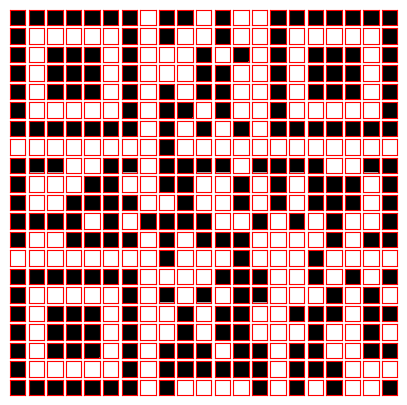

In [ ]:
_, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        col.imshow(qr_cells[i][j], cmap="gray", vmin=0, vmax=255)
        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)
        col.spines[:].set_color('red')

In [ ]:
qr_cells_numeric = np.ndarray((grid_cells_num, grid_cells_num), dtype=np.uint8)
for i, row in enumerate(qr_cells):
    for j, cell in enumerate(row):
        qr_cells_numeric[i, j] = (np.median(cell) // 255)

print(qr_cells_numeric)

[[0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1 0]
 [0 1 0 0 0 1 0 1 1 1 0 1 0 1 0 1 0 0 0 1 0]
 [0 1 0 0 0 1 0 1 1 1 0 0 1 1 0 1 0 0 0 1 0]
 [0 1 0 0 0 1 0 1 0 1 0 0 1 1 0 1 0 0 0 1 0]
 [0 1 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 1 1 0]
 [0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0]
 [0 1 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 1 0]
 [0 1 1 0 0 0 0 1 1 0 1 1 0 1 0 1 0 0 0 1 0]
 [0 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 1 1 0]
 [0 1 1 0 0 0 0 1 0 1 0 0 0 1 1 1 1 0 1 0 0]
 [1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1 0 1 0 1 0]
 [0 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 1]
 [0 1 0 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 1 0 0]
 [0 1 0 0 0 1 0 1 1 0 1 0 0 1 1 1 0 1 1 0 1]
 [0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0]
 [0 1 1 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0 1 1 0]]


In [ ]:
# We want row #8
row=np.flip(qr_cells_numeric[:, 8])

In [ ]:
# The first two bits determine the error correction level
# Level L (Low)         [11]	7%  of data bytes can be restored.
# Level M (Medium)      [10]	15% of data bytes can be restored.
# Level Q (Quartile)    [01]	25% of data bytes can be restored.
# Level H (High)        [00]	30% of data bytes can be restored.
ecl = [int(not(c)) for c in row[ 0:2]]
# Why "not"? Because the standard uses '1's for black and '0's for white
#
# "A dark module is a binary one and a light module is a binary zero."
#  - ISO/IEC 18004:2000(E)
#
# In image processing, we use them the other way.. Hence the inversion
print(ecl)

[1, 1]


In [ ]:
# Dictionary of all masks and their equivalent formulae
MASKS = {
    "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
    "001": lambda i, j: (i // 2 + j // 3) % 2 == 0,
    "010": lambda i, j: ((i + j) % 2 + (i * j) % 3) % 2 == 0,
    "011": lambda i, j: ((i * j) % 2 + (i * j) % 3) % 2 == 0,
    "100": lambda i, j: i % 2 == 0,
    "101": lambda i, j: (i + j) % 2 == 0,
    "110": lambda i, j: (i + j) % 3 == 0,
    "111": lambda i, j: j % 3 == 0,
}

# Same row as above, the three cells after the ecl cells (converted to a string)
mask = [int(not(c)) for c in row[ 2:5]]
mask_str = ''.join([str(c) for c in mask])
print(mask_str)


100


In [ ]:
UP8, UP4, DOWN8, DOWN4, CW8, CCW8 = range(6)
# A more general apply_mask function (still works the same way)
def apply_mask_general(data_start_i, data_start_j, data, mask, direction):
    result = []
    row_offsets = []
    col_offsets = []
    mask_str = ''.join([str(c) for c in mask])
    if (direction in [UP8, UP4]):
        row_offsets = [0,  0, -1, -1, -2, -2, -3, -3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction in [DOWN8, DOWN4]):
        row_offsets = [0,  0,  1,  1,  2,  2,  3,  3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == CW8):
        row_offsets = [0,  0,  1,  1,  1,  1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    if (direction == CCW8):
        row_offsets = [0,  0, -1, -1, -1, -1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    for i, j in zip(row_offsets, col_offsets):
        cell_bit = bool(data[data_start_i+i, data_start_j+j])
        mask_bit = MASKS[mask_str](data_start_i+i, data_start_j+j)
        # Modules corresponding to the dark areas of the mask are inverted.
        result.append(int(not cell_bit if mask_bit else cell_bit))
        # result.append(cell_bit if mask_bit else 1 - cell_bit)
    return result[:4] if direction in [UP4, DOWN4] else result

qr_cells_numeric = 1- qr_cells_numeric
enc_bits = apply_mask_general(grid_cells_num-1, grid_cells_num-1, qr_cells_numeric, mask, UP8)[:4]
print(enc_bits)

len_bits = apply_mask_general(21-3, 21-1, qr_cells_numeric, mask, UP8)
len_int = int(''.join([str(bit) for bit in len_bits]), 2)
print(f'{len_bits} = {len_int} data symbols, each consisting of 8 bits')

block_starting_indices = [
    [21-7,  21-1,  UP8],
    [21-11, 21-1,  CCW8],
    [21-10, 21-3,  DOWN8],
    [21-6,  21-3,  DOWN8],
    [21-2,  21-3,  CW8],
    [21-3,  21-5,  UP8],
    [21-7,  21-5,  UP8],
    [21-11, 21-5,  CCW8],
    [21-10, 21-7,  DOWN8],
    [21-6,  21-7,  DOWN8],
    [21-2,  21-7,  CW8],
    [21-3,  21-9,  UP8],
    [21-7,  21-9,  UP8],
    [21-11, 21-9,  UP8],
    [21-16, 21-9,  UP8],
    [21-20, 21-9,  CCW8],
    [21-19, 21-11, DOWN8],
    [21-14, 21-11, DOWN4],  # Special 4-byte block, reserved for END (if exists!)
    [21-12, 21-11, DOWN8],
    [21-8,  21-11, DOWN8],
    [21-4,  21-11, DOWN8],
    [21-9,  21-13, UP8],
    [21-12, 21-16, DOWN8],
    [21-9,  21-18, UP8],
    [21-12, 21-20, DOWN8],
]

[0, 1, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 1] = 17 data symbols, each consisting of 8 bits


In [ ]:
message_bits = []
message_bits.extend(enc_bits)
message_bits.extend(len_bits)
# Let me re-format this for better readability :)
# First, let's read the data bytes, starting from the very first byte after enc and len
byte_index = 0
for _ in range(len_int):
    start_i, start_j, dir = block_starting_indices[byte_index]
    bits = apply_mask_general(start_i, start_j, qr_cells_numeric, mask, dir)
    message_bits.extend(bits)
    print(bits)
    bit_string = ''.join([str(bit) for bit in bits])
    alpha_char = chr(int(bit_string, 2))
    print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
    byte_index += 1

# After finishing all the characters, the next 4 bits are expected to be '0000'
start_i, start_j, dir = block_starting_indices[byte_index]
bits = apply_mask_general(start_i, start_j, qr_cells_numeric, mask, dir)
message_bits.extend(bits)
# print(bits)
byte_index += 1

# print(byte_index)

for _ in range(25-len_int-1):
    start_i, start_j, dir = block_starting_indices[byte_index]
    bits = apply_mask_general(start_i, start_j, qr_cells_numeric, mask, dir)
    message_bits.extend(bits)
    bit_string = ''.join([str(bit) for bit in bits])
    alpha_char = chr(int(bit_string, 2))
    print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
    byte_index += 1

# print('bit string: ', bit_string)
# print('bits: ', bits)
# For every 8 bits in the extracted message, convert to a byte
message_bytes = [int("".join(map(str, message_bits[i:i+8])), 2) for i in range(0, len(message_bits), 8)]
ecl_str = ''.join([str(bit) for bit in ecl])  # Convert the list to a binary string
print(ecl_str)
ecl_int = int(ecl_str, 2)  # Convert the binary string to an integer
print(ecl_int)
if ecl_int == 3:
    mapped_value = 7
elif ecl_int == 2:
    mapped_value = 15
elif ecl_int == 1:
    mapped_value = 25
else:  # ecl_int == 0
    mapped_value = 30

print('reedsolomon level: ',mapped_value)
# Create the Reed-Solomon Codec for 7 ECC symbols (again, this is L)
rsc = rs.RSCodec(nsym=mapped_value)

message_decoded = rsc.decode(message_bytes)
rsc.maxerrata(verbose=True)

# In order to extract the actual data, need to convert back to bits
# Then take as many bytes as indicated by the message length indicator
# That is AFTER removing the first 12 bytes (of enc and len)


if(enc_bits== [0, 0, 1, 0]):
    data_bits = bin(int.from_bytes(message_decoded[0], byteorder='big'))[13:13+len_int*12]
    # print('data bits: ',data_bits)
    alphanumeric_table = {
        0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
        10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I',
        19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R',
        28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: ' ',
        37: '$', 38: '%', 39: '*', 40: '+', 41: '-', 42: '.', 43: '/', 44: ':'
    }

    # Convert binary string to decimal values
    decimal_values = [int(data_bits[i:i+11], 2) for i in range(0, len(data_bits)-len_int, 11)]
    decimal_values1 = [int(data_bits[i:i+6], 2) for i in range(len(data_bits)-len_int, len(data_bits), 11)]

    # print(decimal_values)

    def find_xy_pairs(max_value, target):
        results = []
        for x in range(max_value + 1):
            y = target - 45 * x
            if 0 <= y <= max_value:
                results.append((x, y))

        return results

    decoded_string=""
    for decimal in decimal_values:
        # print(decimal)
        # print(alphanumeric_table.get(find_xy_pairs(44,decimal)[0][0]))
        # print(alphanumeric_table.get(find_xy_pairs(44,decimal)[0][1], ""))
        decoded_string += alphanumeric_table.get(find_xy_pairs(44,decimal)[0][0], "") + alphanumeric_table.get(find_xy_pairs(44,decimal)[0][1], "")

    for decimal in decimal_values1:
        decoded_string += alphanumeric_table.get(find_xy_pairs(44,decimal)[0][1], "")

    print("Decoded Alphanumeric String:", decoded_string)
else:
    data_bits = bin(int.from_bytes(message_decoded[0], byteorder='big'))[13:13+len_int*8]
    data_bytes = int(data_bits, 2).to_bytes((len(data_bits)+7)//8, 'big')
    print(f'Data in message = "{data_bytes.decode(encoding="iso-8859-1")}"')



[0, 1, 0, 0, 0, 0, 1, 0]
01000010 (=066) = B
[0, 1, 1, 0, 1, 1, 0, 0]
01101100 (=108) = l
[0, 1, 1, 0, 0, 0, 0, 1]
01100001 (=097) = a
[0, 1, 1, 0, 0, 0, 1, 1]
01100011 (=099) = c
[0, 1, 1, 0, 1, 0, 1, 1]
01101011 (=107) = k
[0, 0, 1, 0, 0, 0, 0, 0]
00100000 (=032) =  
[0, 1, 1, 0, 1, 1, 0, 1]
01101101 (=109) = m
[0, 1, 1, 0, 1, 0, 0, 1]
01101001 (=105) = i
[0, 1, 1, 1, 0, 0, 1, 0]
01110010 (=114) = r
[0, 1, 1, 1, 0, 0, 1, 0]
01110010 (=114) = r
[0, 1, 1, 0, 1, 1, 1, 1]
01101111 (=111) = o
[0, 1, 1, 1, 0, 0, 1, 0]
01110010 (=114) = r
[0, 0, 1, 0, 0, 0, 0, 0]
00100000 (=032) =  
[0, 1, 1, 0, 1, 0, 0, 0]
01101000 (=104) = h
[0, 1, 1, 0, 0, 1, 0, 1]
01100101 (=101) = e
[0, 1, 1, 0, 1, 0, 0, 0]
01101000 (=104) = h
[0, 1, 1, 0, 0, 1, 0, 1]
01100101 (=101) = e
01101101 (=109) = m
00111010 (=058) = :
01001111 (=079) = O
01111110 (=126) = ~
11001000 (=200) = È
01110100 (=116) = t
01101110 (=110) = n
11
3
reedsolomon level:  7
This codec can correct up to 3 errors and 7 erasures independently
D

## Decoder Output